# Natural language processing: spam detection with recurrent neural networks

In [1]:
# Handle imports up-front
import regex as re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from statistics import mean 
from sklearn.model_selection import train_test_split, cross_val_score
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

2025-03-31 21:35:13.126444: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Data loading

### 1.1. Load the data

In [2]:
# Read csv file into dataframe
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')

# Drop duplicates if any
data_df.drop_duplicates(inplace=True)
data_df.reset_index(inplace=True, drop=True)

### 1.2. Inspect the data

In [3]:
data_df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2369 entries, 0 to 2368
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2369 non-null   object
 1   is_spam  2369 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 21.0+ KB


### 1.3. Train-test split

In [5]:
# Separate features from labels
labels=data_df['is_spam']
features=data_df.drop('is_spam', axis=1)

# Encode the labels
encoded_labels=labels.apply(lambda x: 1 if x else 0).astype(int)

# Split the data into training and testing features and labels
training_features, testing_features, encoded_training_labels, encoded_testing_labels=train_test_split(
    features,
    encoded_labels,
    test_size=0.25,
    random_state=315
)

## 2. EDA

First, let's just take a look at how many 'spam' vs 'not spam' urls we have:

In [6]:
percent_spam=(sum(encoded_training_labels) / len(encoded_training_labels)) * 100
print(f'Training data is {percent_spam:.1f}% spam urls.')

Training data is 10.6% spam urls.


This is unbalanced, but not extremely so - we may not need to do anything with this information. But, it is good to keep it in mind as we work through EDA and modeling.

### 2.1. Text preprocessing

In [7]:
def preprocess_text(text):

    # Remove any character that is not a letter (a-z) or white space ( )
    text=re.sub(r'[^a-z ]', ' ', text)
    
    # Remove white spaces
    text=re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text=re.sub(r'\^[a-zA-Z]\s+', ' ', text)

    # Multiple white spaces into one
    text=re.sub(r'\s+', ' ', text.lower())

    # Remove tags
    text=re.sub('&lt;/?.*?&gt;',' &lt;&gt; ', text)

    # Remove 'http', 'https' and 'www'
    # text=re.sub('https', '', text)
    # text=re.sub('http', '', text)
    text=re.sub('www', '', text)

    return text.split()

training_features['url']=training_features['url'].apply(preprocess_text)
testing_features['url']=testing_features['url'].apply(preprocess_text)
training_features.head()

,url
311,"[https, nytimes, com, us, into, the, wild, bus..."
2317,"[https, digg, cmail, com, t, ptuurik, vkjjhbly..."
1953,"[http, snarkmarket, com]"
1872,"[https, youtube, com, watch, d, u]"
1752,"[https, wired, com, story, amazon, shakes, sel..."


### 2.2. Lematization

In [8]:
download('wordnet')
lemmatizer=WordNetLemmatizer()

# download('stopwords')
stop_words=stopwords.words('english')

def lemmatize_text(words, lemmatizer=lemmatizer):
    tokens=[lemmatizer.lemmatize(word) for word in words]
    tokens=[word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

training_features['url']=training_features['url'].apply(lemmatize_text)
testing_features['url']=testing_features['url'].apply(lemmatize_text)
training_features.head()

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,url
311,"[http, nytimes, wild, removed, html]"
2317,"[http, digg, cmail, ptuurik, vkjjhbly]"
1953,"[http, snarkmarket]"
1872,"[http, youtube, watch]"
1752,"[http, wired, story, amazon, shake, self, driv..."


### 2.3. URL length distribution

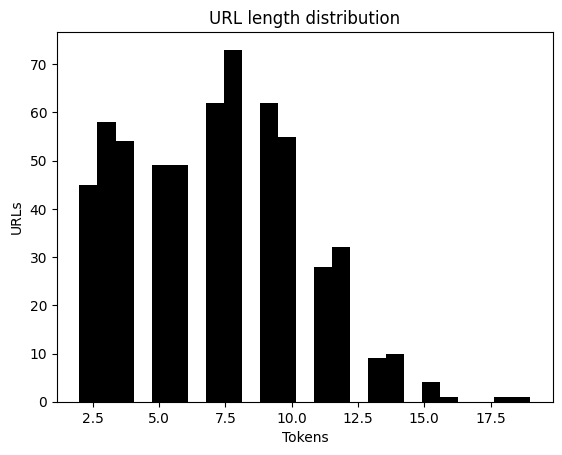

URL length mean: 7 tokens
URL length min: 2 tokens
URL length max: 19 tokens


In [9]:
# Get the lengths (in tokens)
lengths=[len(url) for url in training_features['url'].tolist()]

# Add it back to the data as a new feature
training_features['url_len']=lengths

# Same for the testing data
lengths=[len(url) for url in testing_features['url'].tolist()]
testing_features['url_len']=lengths

plt.title('URL length distribution')
plt.xlabel('Tokens')
plt.ylabel('URLs')
plt.hist(lengths, bins=25, color='black')
plt.show()

print(f'URL length mean: {mean(lengths):.0f} tokens')
print(f'URL length min: {min(lengths):.0f} tokens')
print(f'URL length max: {max(lengths):.0f} tokens')

We have at least one URL with length zero after out text cleaning. Let's get rid of it.

In [10]:
# Add the labels back temporarily, so we can remove the corresponding label with url
training_features['target']=encoded_training_labels
training_features=training_features[training_features['url_len'] > 0]

testing_features['target']=encoded_testing_labels
testing_features=testing_features[testing_features['url_len'] > 0]

# Re-separate the features and labels
encoded_training_labels=training_features['target']
training_features.drop(['target'], axis=1, inplace=True)

encoded_testing_labels=testing_features['target']
testing_features.drop(['target'], axis=1, inplace=True)

We also have some long urls, let's take a look at what they are and decide if we should exclude them.

In [11]:
training_features[training_features['url_len'] > 15]

,url,url_len
2159,"[http, washingtonpost, politics, court, suprem...",17
2142,"[http, ohio, news, ohio, university, professor...",16
219,"[http, judiciary, senate, press, release, chai...",17
1433,"[http, marketwatch, story, reason, stock, mark...",16
2320,"[http, washingtonpost, local, public, safety, ...",16
319,"[http, reuters, article, stock, weekahead, wal...",17
1866,"[http, washingtonpost, national, security, rus...",18
1724,"[http, section, live, update, protest, racial,...",16
2334,"[http, reuters, article, russia, putin, vote, ...",17
2077,"[http, blog, microsoft, blog, microsoft, launc...",17


These mostly look like news sites that pack a lot of article key words into the URL. You could accuse them of key-word stuffing for SEO/sensationalism, but these are not obviously 'junk' data points. Let's keep them in.

In [12]:
# Extract the tokenized URLs and join the individual lists
training_tokens=training_features['url']
training_tokens=np.array([' '.join(tokens).encode('UTF-8') for tokens in training_tokens])

testing_tokens=testing_features['url']
testing_tokens=np.array([' '.join(tokens).encode('UTF-8') for tokens in testing_tokens])

training_tokens[:5]

array([b'http nytimes wild removed html',
       b'http digg cmail ptuurik vkjjhbly', b'http snarkmarket',
       b'http youtube watch',
       b'http wired story amazon shake self driving ride hailing'],
      dtype='|S167')

## 3. RNN model

### 3.1. Validation data

In [13]:
# Split the data into training and testing features and labels
training_features, validation_features, training_labels, validation_labels=train_test_split(
    training_tokens,
    encoded_training_labels,
    test_size=0.3
)

training_features=tf.convert_to_tensor(training_features)
validation_features=tf.convert_to_tensor(validation_features)

training_features[:5]

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'http blog ferriss show transcript caroline paul',
       b'http usatoday stans spamming explained',
       b'http podcasts apple podcast mask girl summer', b'http foldnfly',
       b'http courier journal story news politics election kentucky kentucky senate primary election result booker mcgrath'],
      dtype=object)>

### 3.2. Text encoding

In [14]:
encoder=tf.keras.layers.TextVectorization(output_mode="int")
encoder.adapt(training_features)

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'http', 'html', 'news', 'article', 'coronavirus',
       'story', 'nytimes', 'youtube', 'trump', 'watch', 'morningbrew',
       'numlock', 'world', 'reuters', 'daily', 'substack', 'medium',
       'covid'], dtype='<U32')

### 3.2. Model definition

In [15]:
model=tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=['accuracy']
)

### 3.3. Class weighting

In [16]:
total=len(training_labels)
pos=sum(training_labels)
neg=total-pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.56
Weight for class 1: 4.78


### 3.3. Model training


CPU times: user 3min 45s, sys: 6.46 s, total: 3min 52s
Wall time: 2min 44s


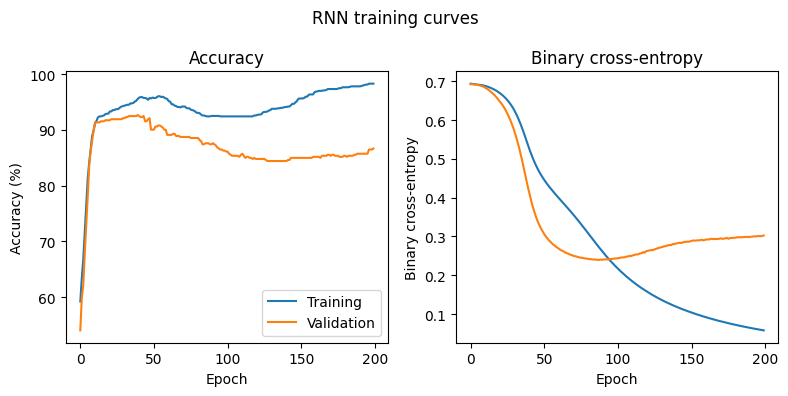

In [17]:
%%time

training_results=model.fit(
    training_features,
    training_labels,
    epochs=200,
    validation_data=(validation_features,validation_labels),
    class_weight=class_weight,
    verbose=0
)

# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('RNN training curves', size='large')

# Plot training and validation accuracy
axs[0].set_title('Accuracy')
axs[0].plot(np.array(training_results.history['accuracy']) * 100, label='Training')
axs[0].plot(np.array(training_results.history['val_accuracy']) * 100, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(loc='best')

# Plot training and validation binary cross-entropy
axs[1].set_title('Binary cross-entropy')
axs[1].plot(training_results.history['loss'])
axs[1].plot(training_results.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary cross-entropy')

fig.tight_layout()

print()

### 3.2. Regularization


CPU times: user 9min 19s, sys: 15.2 s, total: 9min 34s
Wall time: 6min 37s


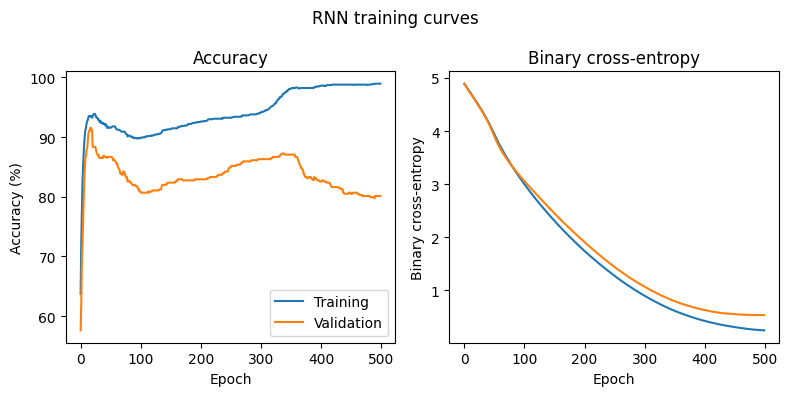

In [19]:
%%time

# Add regularization to the model
regularizer=tf.keras.regularizers.L1L2(l1=0.02, l2=0.002)

model=tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizer),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Re-compile
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=['accuracy']
)

# Re-train
training_results=model.fit(
    training_features,
    training_labels,
    epochs=500,
    validation_data=(validation_features,validation_labels),
    class_weight=class_weight,
    verbose=0
)

# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('RNN training curves', size='large')

# Plot training and validation accuracy
axs[0].set_title('Accuracy')
axs[0].plot(np.array(training_results.history['accuracy']) * 100, label='Training')
axs[0].plot(np.array(training_results.history['val_accuracy']) * 100, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(loc='best')

# Plot training and validation binary cross-entropy
axs[1].set_title('Binary cross-entropy')
axs[1].plot(training_results.history['loss'])
axs[1].plot(training_results.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary cross-entropy')

fig.tight_layout()

print()

## 4. Model evaluation

### 4.1. Test set predictions

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


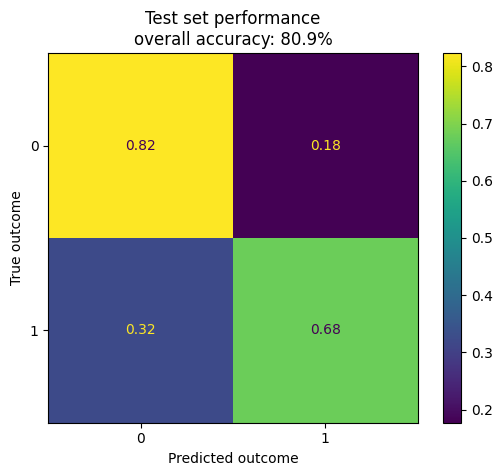

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

threshold=0.5
predictions=model.predict(tf.convert_to_tensor(testing_tokens))
predictions=[1 if p > threshold else 0 for p in predictions]

accuracy=accuracy_score(predictions, encoded_testing_labels)*100

# Plot the confusion matrix
cm=confusion_matrix(encoded_testing_labels, predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot()

plt.title(f'Test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted outcome')
plt.ylabel('True outcome')
plt.show()